## EDA 

In [25]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline, Pipeline

import warnings
warnings.simplefilter('ignore')

In [26]:
# Import library
df = pd.read_csv('./data/WRactive_4th.csv')
df.shape

(171, 17)

In [27]:
df.sample()

,Unnamed: 0,Player,ht_inch,draftTeam,draftStat,draftRnd,Wt,dash,Yds_1,TD_1,Yds_2,TD_2,Yds_3,TD_3,Yds_4,TD_4,Salary
57,271,Devin Hester,71,Chicago Bears,Yes,2,190,4.41,0,0,299,2,665,3,757,3,637450.0


In [28]:
# Drop first column
df = df.drop(columns ='Unnamed: 0',axis=1)


In [29]:
df.head(2)

,Player,ht_inch,draftTeam,draftStat,draftRnd,Wt,dash,Yds_1,TD_1,Yds_2,TD_2,Yds_3,TD_3,Yds_4,TD_4,Salary
0,Plaxico Burress,77,Pittsburgh Steelers,Yes,1,231,4.59,273,0,1008,6,1325,7,860,4,591300.0
1,Laveranues Coles,71,New York Jets,Yes,3,192,4.41,370,1,868,7,1264,5,1204,6,689850.0


In [30]:
print(len(df.columns), df.columns)

16 Index(['Player', 'ht_inch', 'draftTeam', 'draftStat', 'draftRnd', 'Wt', 'dash',
       'Yds_1', 'TD_1', 'Yds_2', 'TD_2', 'Yds_3', 'TD_3', 'Yds_4', 'TD_4',
       'Salary'],
      dtype='object')


In [31]:
for ind,col in enumerate(df.columns):
    print(ind, col)

0 Player
1 ht_inch
2 draftTeam
3 draftStat
4 draftRnd
5 Wt
6 dash
7 Yds_1
8 TD_1
9 Yds_2
10 TD_2
11 Yds_3
12 TD_3
13 Yds_4
14 TD_4
15 Salary


In [32]:
# What's the range of salaries?

df[ (df.Salary == df.Salary.min()) | (df.Salary == df.Salary.max()) ]

,Player,ht_inch,draftTeam,draftStat,draftRnd,Wt,dash,Yds_1,TD_1,Yds_2,TD_2,Yds_3,TD_3,Yds_4,TD_4,Salary
78,Onrea Jones,71,NaN,No,0,202,4.42,0,0,0,0,0,0,0,0,160020.0
149,Mike Williams,73,Tampa Bay Buccaneers,Yes,4,221,4.53,964,11,771,3,996,9,216,2,7740000.0


In [33]:
# Who made less than $ 250,000?

df[df['Salary'] < (0.25 * 1e7)].sort_values(by='Salary', ascending=False).head()


,Player,ht_inch,draftTeam,draftStat,draftRnd,Wt,dash,Yds_1,TD_1,Yds_2,TD_2,Yds_3,TD_3,Yds_4,TD_4,Salary
6,Peter Warrick,71,Cincinnati Bengals,Yes,1,194,4.58,592,4,667,1,606,6,819,7,2417760.0
19,Anquan Boldin,73,Arizona Cardinals,Yes,2,216,4.72,1377,8,623,1,1402,7,1203,4,2136750.0
53,Miles Austin,74,NaN,No,0,215,4.47,0,0,76,0,278,3,1320,11,1790655.0
135,Dez Bryant,74,Dallas Cowboys,Yes,1,225,4.52,561,6,928,9,1382,12,1233,13,1674312.5
127,Mike Thomas,68,Jacksonville Jaguars,Yes,4,195,4.30,453,1,820,4,415,1,108,1,1580500.0


Text(0.5, 1.0, 'ACTIVE Players')

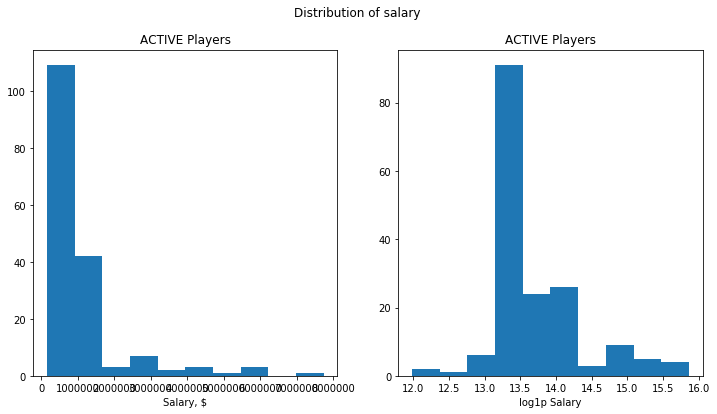

In [34]:
# What's the distribvution of salary
plt.figure(figsize=(12,6))

plt.suptitle('Distribution of salary')

plt.subplot(1,2,1)
plt.hist(df['Salary'])
plt.xlabel('Salary, $')
plt.title('ACTIVE Players')

plt.subplot(1,2,2)
plt.hist(np.log1p(df['Salary']))
plt.xlabel('log1p Salary')
plt.title('ACTIVE Players')

In [35]:
# Turning Yards TDs into fantasy points
#<<< [10 yds = 1 point]  and  [1 TD = 4 point]

df['yr1'] = df['Yds_1']/ 10  + df['TD_1']* 6
df['yr2'] = df['Yds_2']/ 10  + df['TD_2']* 6
df['yr3'] = df['Yds_3']/ 10  + df['TD_3']* 6
df['yr4'] = df['Yds_4']/ 10  + df['TD_4']* 6
df['Salary_log1p'] = np.log1p(df['Salary'])

In [36]:
selectcol= ['yr1','yr2','yr3','yr4', 'Salary_log1p']
df[selectcol].head()

,yr1,yr2,yr3,yr4,Salary_log1p
0,27.3,136.8,174.5,110.0,13.290080
1,43.0,128.8,156.4,156.4,13.444231
2,0.6,22.0,122.8,42.1,13.323945
3,21.4,0.0,0.0,0.0,13.134077
4,45.6,74.0,122.9,81.2,13.895003


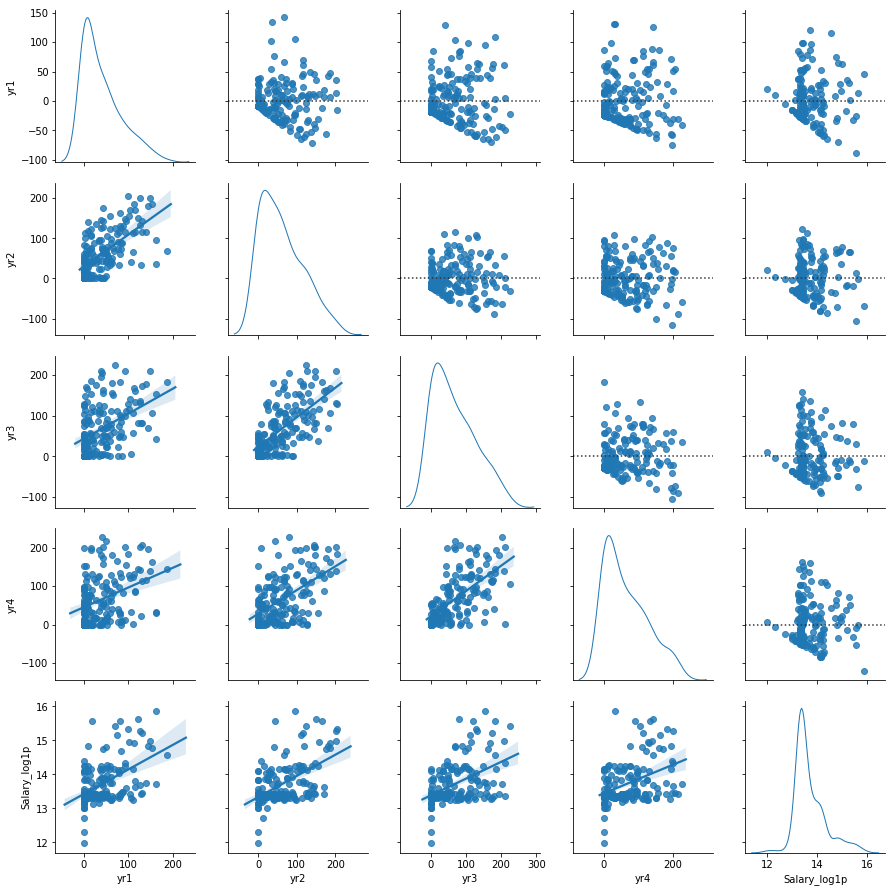

In [37]:
# Pair Plot everything, ACTIVE

g = sns.PairGrid(df.loc[:,selectcol], diag_sharey=False)
g.map_lower(sns.regplot)
g.map_upper(sns.residplot)
g.map_diag(sns.kdeplot, lw=1)


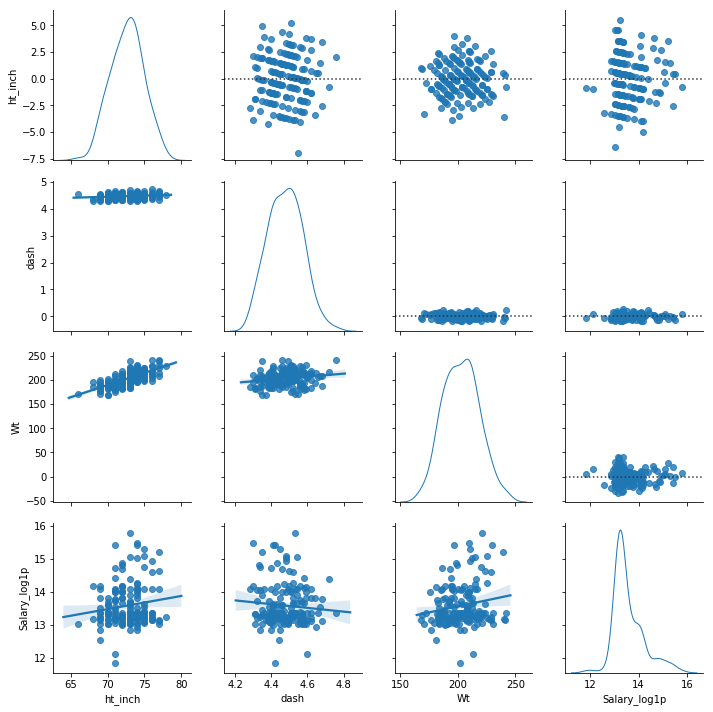

In [17]:
# Pairplot Combine, ACTIVE
selectcol2= ['ht_inch','dash','Wt','Salary_log1p']

g = sns.PairGrid(df.loc[:,selectcol2], diag_sharey=False)
g.map_lower(sns.regplot)
g.map_upper(sns.residplot)
g.map_diag(sns.kdeplot, lw=1)
